# Experimento 4: Red preentrenada

Necesario: fichero de pesos de vgg16 en carpeta ./data/

In [2]:
import numpy as np 
import pandas as pd 
import os, time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from keras.utils  import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16;
from keras.applications.vgg16 import preprocess_input
import os

In [3]:
train_data = pd.read_csv('./data/fashion-mnist_train.csv')
test_data  = pd.read_csv('./data/fashion-mnist_test.csv')

In [4]:
train_data.shape 
test_data.shape 
train_X= np.array(train_data.iloc[:,1:])
test_X = np.array(test_data.iloc[:,1:])
train_Y= np.array (train_data.iloc[:,0]) 
test_Y = np.array(test_data.iloc[:,0]) 

In [5]:
train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
train_X.shape, test_X.shape

((60000, 784), (10000, 784))

In [7]:
classes = np.unique(train_Y)
num_classes = len(classes)
num_classes

10

In [8]:
# Pasar las imágenes a 3 canales (R-G-B) (REQUERIDO POR VGG16)
train_X =np.dstack([train_X] * 3)
test_X  =np.dstack([test_X]*3)
train_X.shape,test_X.shape

((60000, 784, 3), (10000, 784, 3))

In [9]:
# Reestructuras imágenes al formato requerido por los modelos de cnn
train_X = train_X.reshape(-1, 28,28,3)
test_X  = test_X.reshape (-1,28,28,3)
train_X.shape,test_X.shape

((60000, 28, 28, 3), (10000, 28, 28, 3))

In [10]:
# Reestructurar al formato adecuado necesario para VGG16 
from keras.preprocessing.image import img_to_array, array_to_img
train_X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in train_X])
test_X  = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in test_X])
train_X.shape, test_X.shape

((60000, 48, 48, 3), (10000, 48, 48, 3))

In [11]:
train_X = train_X / 255.
test_X  = test_X / 255.
train_X = train_X.astype('float32')
test_X  = test_X.astype('float32')

In [12]:
# Adaptar los labels (y_test, y_train) para que sean aceptados por cnn (igual que en el resto
# de experimentos hasta ahora)
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot  = to_categorical(test_Y)

In [13]:
# Extraer conjuntos de train, validación y test 
train_X,valid_X,train_label,valid_label = train_test_split(train_X,
                                                           train_Y_one_hot,
                                                           test_size=0.2,
                                                           random_state=13
                                                           )

In [14]:
# Revisar los tamaños y estrcutura de los datos para comprobar que son correctos
train_X.shape,valid_X.shape,train_label.shape,valid_label.shape

((48000, 48, 48, 3), (12000, 48, 48, 3), (48000, 10), (12000, 10))

In [15]:
# Parámetros necesarios 
IMG_WIDTH = 48
IMG_HEIGHT = 48
IMG_DEPTH = 3
BATCH_SIZE = 16

In [17]:
# CArgar modelo base VGG16
conv_base = VGG16(weights='./data/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                  include_top=False, 
                  input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH)
                 )
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

In [18]:
# CREAR NUESTRO MODELO

from keras import models
from keras import layers

model = Sequential()
model.add(conv_base)        # modelo base agradado como una capa!
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [23]:
# Entrenar, y al mismo tiempo, validar 

import time
start_time = time.time()

history = model.fit(train_X,train_label,
          epochs=15, batch_size=128,verbose=1, 
          validation_data=( valid_X, valid_label ) )

training_time = time.time() - start_time
print(training_time)

Epoch 1/15
375/375 [==============================] - 2942s 8s/step - loss: 0.3575 - accuracy: 0.8654 - val_loss: 0.3311 - val_accuracy: 0.8761
Epoch 2/15
375/375 [==============================] - 2174s 6s/step - loss: 0.2899 - accuracy: 0.8902 - val_loss: 0.2917 - val_accuracy: 0.8928
Epoch 3/15
375/375 [==============================] - 2188s 6s/step - loss: 0.2555 - accuracy: 0.9040 - val_loss: 0.2795 - val_accuracy: 0.8986
Epoch 4/15
375/375 [==============================] - 2185s 6s/step - loss: 0.2302 - accuracy: 0.9124 - val_loss: 0.2628 - val_accuracy: 0.9044
Epoch 5/15
375/375 [==============================] - 2150s 6s/step - loss: 0.2046 - accuracy: 0.9232 - val_loss: 0.2454 - val_accuracy: 0.9107
Epoch 6/15
375/375 [==============================] - 2189s 6s/step - loss: 0.1896 - accuracy: 0.9291 - val_loss: 0.2561 - val_accuracy: 0.9122
Epoch 7/15
375/375 [==============================] - 2628s 7s/step - loss: 0.1908 - accuracy: 0.9297 - val_loss: 0.2425 - val_accuracy:

In [30]:
import math as mt
def average(numbers):
    """
    Calcula la media aritmética simple
    """
    try:
        return float(sum(numbers)) / max(len(numbers), 1)
    except ZeroDivisionError:
        return 0

media_acc = average(history.history['accuracy'])
print('Acierto medio sobre train = ' , media_acc)

media_acc_val = average(history.history['val_accuracy'])
print('Acierto medio sobre valid. = ' , media_acc_val)


Acierto medio sobre train =  0.9312722245852153
Acierto medio sobre train =  0.9086333354314168


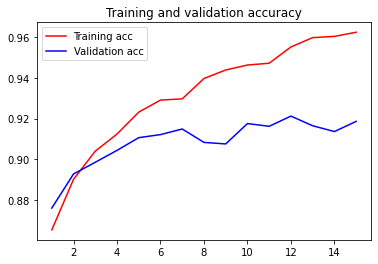

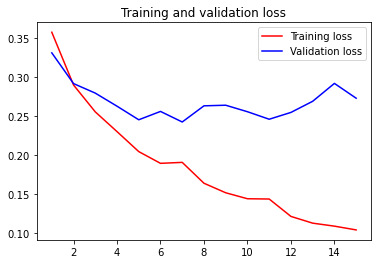

In [26]:
# pintar loss y accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()
